In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model,load_model

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info = True,
    as_supervised = True,
    shuffle_files = True,
    split = ['train']
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete58WPXO/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE)).take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE)).skip(int(VAL_RATIO*DATASET_SIZE))#.take(int(TEST_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()))
# print(list(val_dataset.take(1).as_numpy_iterator()))
# print(list(test_dataset.take(1).as_numpy_iterator()))




## Data Visualization

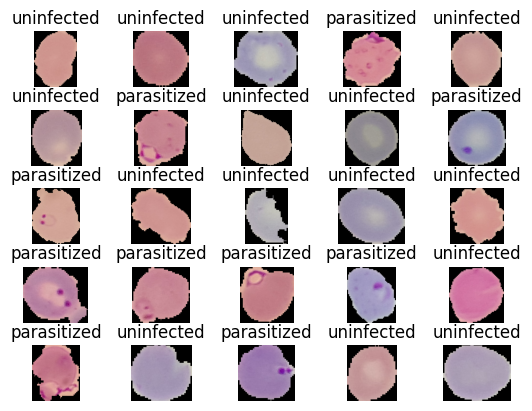

In [5]:
for i, (image, label) in enumerate(train_dataset.take(25)):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  plt.axis('off')

## Data Processing - Resizing, Normalization

In [6]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [7]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [8]:
# for image, label in train_dataset.take(1):
#   print(image, label)

print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [9]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Building Convnets with Tensorflow - Model Creation

In [13]:
model = tf.keras.Sequential()
model.add(InputLayer(
    input_shape = (IM_SIZE, IM_SIZE, 3)
))

# 1st Conv #
model.add(tf.keras.layers.Conv2D(
    filters = 6,
    kernel_size = 3,
    strides = 1,
    padding='valid',
    activation = 'relu'
))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2, strides = 2))

# 2nd Conv #
model.add(tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = 3,
    strides = 1,
    padding='valid',
    activation = 'relu'
))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = 2, strides = 2))

# Flatten #
model.add(Flatten())

# NN #
model.add(Dense(100,activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(10,activation = "relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation = "sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

# Binary CrossEntropy

In [14]:
# y_true = [0,]
# y_pred = [0.02,]
# bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
# bce(y_true, y_pred)

In [15]:
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy'
)
              #metrics = RootMeanSquaredError()


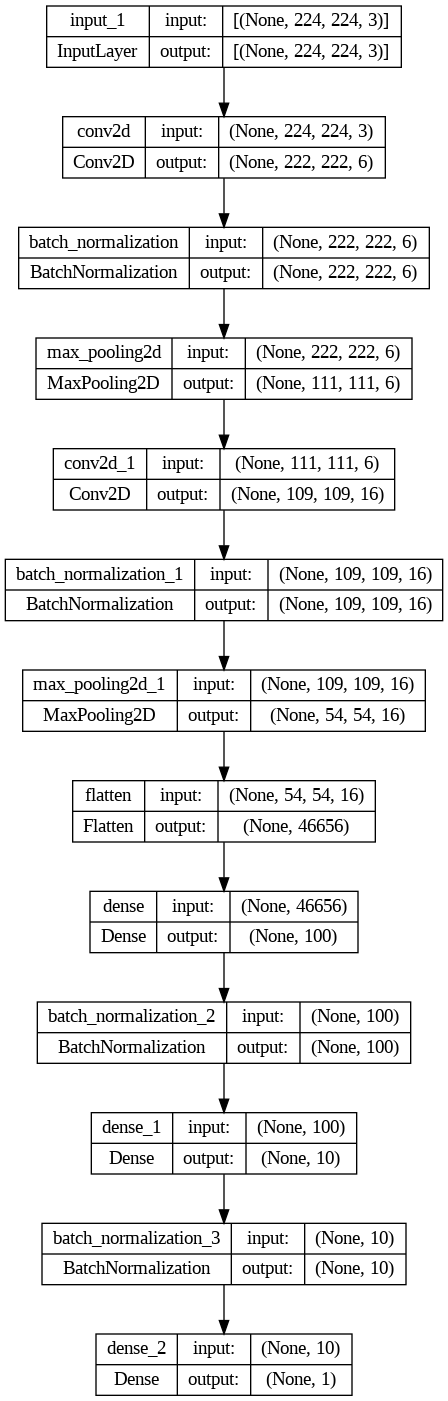

In [22]:
plot_model(model,to_file = "model.png",show_shapes=True)

In [23]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
689/689 [==============================] - 44s 64ms/step - loss: 0.2102 - accuracy: 0.9285 - val_loss: 0.1681 - val_accuracy: 0.9456
Epoch 2/20
689/689 [==============================] - 43s 63ms/step - loss: 0.1781 - accuracy: 0.9410 - val_loss: 0.6116 - val_accuracy: 0.9049
Epoch 3/20
689/689 [==============================] - 42s 62ms/step - loss: 0.1663 - accuracy: 0.9448 - val_loss: 0.3660 - val_accuracy: 0.9176
Epoch 4/20
689/689 [==============================] - 44s 63ms/step - loss: 0.1538 - accuracy: 0.9493 - val_loss: 0.7710 - val_accuracy: 0.5445
Epoch 5/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1409 - accuracy: 0.9555 - val_loss: 0.2577 - val_accuracy: 0.9387
Epoch 6/20
689/689 [==============================] - 42s 61ms/step - loss: 0.1321 - accuracy: 0.9564 - val_loss: 0.2749 - val_accuracy: 0.9448
Epoch 7/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1187 - accuracy: 0.9595 - val_loss: 0.1789 - val_accuracy:

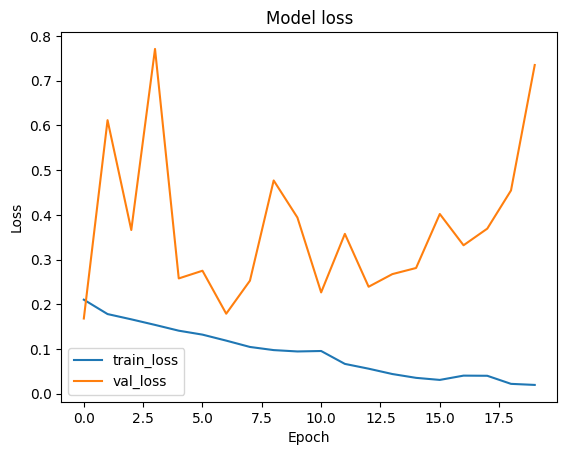

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

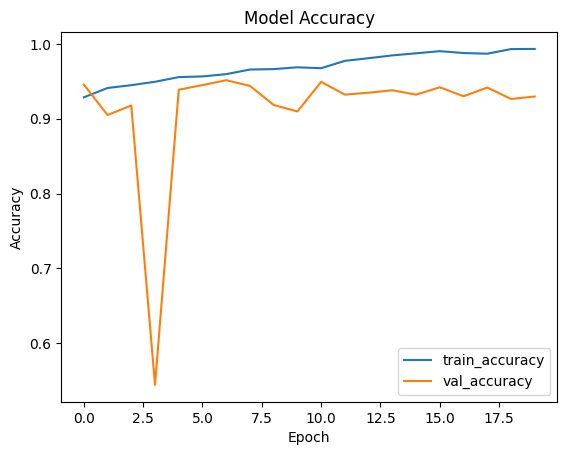

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

## 학습된 모델 저장하기

In [26]:
# malaria_saved_model = '/content/drive/MyDrive/ml/tflite'
# tf.saved_model.save(model, malaria_saved_model)

## tf lite로 변환

In [27]:
# converter = tf.lite.TFLiteConverter.from_saved_model(malaria_saved_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

# tflite_model_file = '/content/drive/MyDrive/ml/malaria_model.tflite'
# with open(tflite_model_file, "wb") as f:
#   f.write(tflite_model)

## Model Evaluation and Testing

In [28]:
test_dataset = test_dataset.batch(1)

In [29]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.6406 - accuracy: 0.9333


[0.6405825614929199, 0.9332607984542847]

In [31]:
# p = 0, unin = 1
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [32]:
print(model.predict(test_dataset.take(1))[0][0])
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 14s 14s/step
0.9956281
1/1 [==============================] - 11s 11s/step


'U'

1/1 [==============================] - 0s 29ms/step


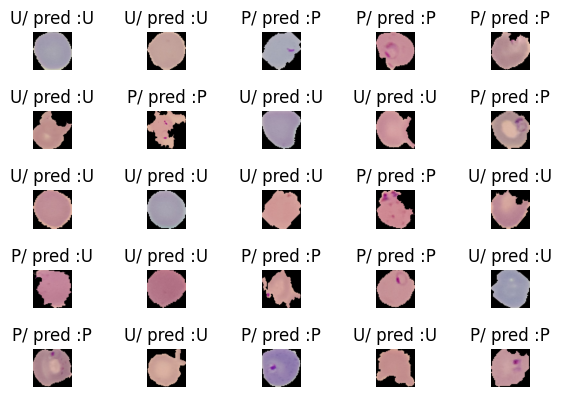

In [36]:
for i,(image, label) in enumerate(test_dataset.take(25)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) +"/ pred :"+str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

plt.subplots_adjust(wspace=2, hspace=0.5)
plt.show()

# Saving to and loading from google drive

## 모델저장하기

In [39]:
save_model(model,'/content/drive/MyDrive/ml/malaria_model.h5')
#load_model = load_model('/content/drive/MyDrive/ml/malaria_model.h5')

<ipython-input-39-6eb55edad870>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,'/content/drive/MyDrive/ml/malaria_model.h5')


## 모델의 가중치만 저장하기 & 로드 후 사용법

In [ ]:
## model.save_weights('/content/drive/My Drive/my_model_weights.h5')
## model.load_weights('/content/drive/My Drive/my_model_weights.h5')

'''

모델의 가중치를 불러온 후에는 해당 가중치를 모델에 적용해야 합니다. TensorFlow의 경우 load_weights() 메서드를 사용하여 모델에 가중치를 로드할 수 있습니다. 이 메서드는 모델의 레이어에 저장된 가중치를 불러옵니다. 다음은 가중치를 로드하고 모델에 적용하는 예제입니다.

python
Copy code
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 모델 구성
model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델의 가중치 불러오기
model.load_weights('/content/drive/My Drive/my_model_weights.h5')

# 모델 컴파일 (선택적)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 가중치가 적용된 모델 사용 예제
predictions = model.predict(test_data)
'''
